In [1]:
run ../cadet_process_utils.ipynb # this has all the required libraries and imports

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject


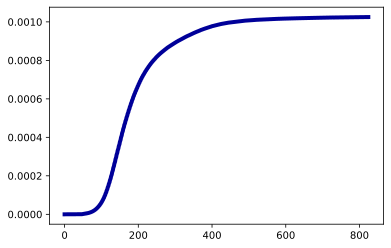

In [2]:
# Import Data
mydata = np.loadtxt('../MSSpCC_PorosityDispersion_CADETEstimation/1ML_PorosityDispersion_Data/75cmph/75cmph_1.csv', delimiter=',')
time = mydata[:,0]*60 # Convert time data from minutes to seconds
conductivity = mydata[:,1]
concentration = ((conductivity/1000)*0.64)/58.44
plt.plot(time,concentration)

In [3]:
# Set Parameters
inlet_conc = 1000 # 1M NaCl = 1000 mol m-3
feed_flowrate = 0.48 # ml/min
vol_flowrate = feed_flowrate*((1e-6)/60) # m^3 s-1, Convert feed flow rate units
col_length = 2.5 # cm, column length
col_ID = 0.7 # cm, column inner diameter
col_csa = np.pi*(col_ID/100)**2 # m^2, column cross sectional area
particle_diameter = 5e-5 # m, MSSpCC particle diameter
sim_duration = 1200 # s, Equivalent to the load time

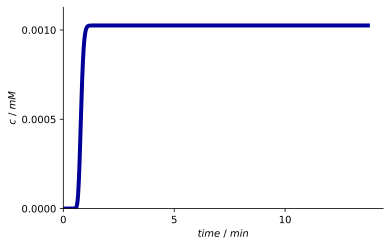

In [4]:
component_system = ComponentSystem(1) # One component, i.e. target protein or material
binding_model = NoBinding(component_system, name='nobinding')
feed_unit = Source(component_system, name='feed')
feed_unit.c = [max(concentration)]
column = LumpedRateModelWithPores(component_system,name='column')
column.length = col_length/100 # m
column.diameter = col_ID/100 # m
column.axial_dispersion = 1e-7
column.bed_porosity = 0.4 # -
column.particle_porosity = 0.4 # -
column.particle_radius = particle_diameter/2 # m
column.film_diffusion = [0] #
column.binding_model = binding_model # Attach the configured binding model to the column
outlet = Sink(component_system, name='outlet')
flow_sheet = FlowSheet(component_system)
flow_sheet.add_unit(feed_unit)
flow_sheet.add_unit(column)
flow_sheet.add_unit(outlet)
flow_sheet.add_connection(feed_unit, column)
flow_sheet.add_connection(column, outlet)
process = Process(flow_sheet, 'process')
process.cycle_time = time[-1]
process.add_event('feed_on', 'flow_sheet.feed.flow_rate', vol_flowrate, 0)
process_simulator = Cadet()
simulation_results = process_simulator.simulate(process)
_ = simulation_results.solution.column.outlet.plot()

In [5]:
comparator = Comparator()
reference = ReferenceIO('Exp_1', time, concentration)
comparator.add_reference(reference)
comparator.add_difference_metric('Shape', reference, 'column.outlet')
metrics = comparator.evaluate(simulation_results)
print(metrics)
_ = comparator.plot_comparison(simulation_results)
optimization_problem = OptimizationProblem('MSSpCC')
optimization_problem.add_evaluation_object(process)
optimization_problem.add_variable('flow_sheet.column.bed_porosity', lb=0, ub=1)
optimization_problem.add_variable('flow_sheet.column.axial_dispersion', lb=1e-8, ub=1e-5)
optimization_problem.add_variable('flow_sheet.column.particle_porosity', lb=0, ub=1)
optimization_problem.add_evaluator(process_simulator)
optimization_problem.add_objective(comparator, requires=[process_simulator])
optimizer = U_NSGA3()
optimizer.pop_size = 100
optimizer.n_max_gen = 50
optimizer.n_cores = 4
optimization_results = optimizer.optimize(optimization_problem,use_checkpoint=True,)

[0.2982550203561769, 29.22933932898298, 4.721759734856038e-06]


AttributeError: module 'hopsy' has no attribute 'UniformModel'

In [ ]:
# print(binding_model.parameters)

# print(column.parameters)

# print(process.parameters)
